# Introduction to Data Science – Homework 6
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, March 01 2024, 11:59pm.

In Part 1 of this homework you will scrape github repositories and organize the information in a Pandas dataframe. In Part 2, you will use linear regression to gain meaningful insights. 

## Your Data
First Name: Logan
<br>
Last Name: Correa
<br>
E-mail: u1094034@umail.utah.edu
<br>
UID: u1094034
<br>

In [170]:
# imports and setup 
from bs4 import BeautifulSoup
# you can use either of these libraries to get html from a website
import time
import os

import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 
# where the data is stored
DATA_PATH = "data"

### 1. Scrape Github Repository List using BeautifulSoup
In this part you will explore Github repositories, specifically the 100 most-starred repositories. You are going to scrape data from a snapshot of [this repository list](https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories).

### 1.1. Check whether you are permitted to scrape the data
Before you start to scrape any website you should go through the terms of service and policy documents of the website. Almost all websites post conditions to use their data. Check the terms of [https://github.com/](https://github.com/) (see the tiny "terms" link at the bottom of the page) to see whether the site permits you to scrape their data or not. Are you sure you are allowed to scrape?

**Your solution:**

Scraping is allowed for researchers as long as published works are open access and the information is not used for spamming purposes.

### Task 1.2 Load the Data

To avoid any problems with GitHub blocking us from downloading the data many times, we have downloaded and saved a snapshot of the html files for you in the [data](data) folder. Note that the data folder is not completely consistent with what you see on the web – we've made a few patches to the data that makes your task here easier and this data represents a snapshot in time. You will be treating the data folder as your website to be scraped. The path to data folder is stored in `DATA_PATH` variable.

In the data folder you will find first 10 pages of highly starred repositories saved as `searchPage1.html`,`searchPage2.html`,`searchPage3.html` ... `searchPage10.html`

Check out page 10 if you want to see what happens if you scrape too quickly 😉. 

Now read these html files in python and create a soup object. This is a two step process:
 * Read the text in the html files
 * Create the soup from the files that you've read. 

In [171]:
# Read html files and create soup files
html_pages = []
for files in os.listdir(DATA_PATH):
    if files.endswith(".html"):
        full_path = os.path.join(DATA_PATH, files)
        with open(full_path, 'r') as f:
            html_pages.append(f.read())

SearchPage_soup = []
for page in html_pages:
    SearchPage_soup.append(BeautifulSoup(page, 'html.parser'))

len(SearchPage_soup)

10

### Extracting Data

Extract the following data for each repository, and create a Pandas Dataframe with a row for each repository and a column for each of these datums. 

+ The name of the repository
+ The primary language (there are multiple or none, if multiple, use the first one, if none, use "none")
+ The number of watches
+ The number of stars
+ The number of forks
+ The number of issues
+ Number of commits
+ Number of contributors
+ Number of pull requests, and
+ Number of top level folders in the file list.

Here's an example for one repository, `jackfrued/Python-100-Days,` in our dataset: 
```python
{'name': 'Python-100-Days',
'language': 'Jupyter Notebook',
'watches': '4822',
'stars': '78068',
'forks': '30979',
'issues': 224,
'commits': 296,
'contributors': 12,
'pull_requests':85,
'folders': 14
}
```

### Task 1.3 Extract repository URLs

If you look at the results of the 100 most-starred repositories [(this list)](https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories), you will notice that all the information we want to extract for each repository is not in that list. This information is in the repository’s individual web page, for example [996icu](https://github.com/996icu/996.ICU). 

Therefore, you will first have to extract links of each repository from the soup you scraped earlier. When you extract the link for the repository, it will be a path to the stored HTML page for the repository. You will use this path to read the file and extract the above information.

Refer to the scraping lecture for details on how to do this. We recommend you use the web inspector to identify the relevant structures.

Example of a link that you need to extract - 996icu/996.ICU.html

In [172]:

# Extract all 'div' elements with class "mt-n1" (these classes contain individual repositories) from each item in SearchPage_soup.
repositories = []

for i in range(0, len(SearchPage_soup)):
    mtn1 = SearchPage_soup[i].find_all('div', class_="mt-n1")
    for item in mtn1:
        repo_links = item.find('a', class_="v-align-middle")
        repositories.extend(repo_links.text.split())

repositories = [repo_path + '.html' for repo_path in repositories]

htmls = []

for repo_path in repositories:
    # Construct the full path to the .html file
    full_file_path = os.path.join(DATA_PATH, repo_path)

    # Check if the file exists
    if os.path.isfile(full_file_path):
        # Open and read the file
        with open(full_file_path, 'r') as file:
            html_content = file.read()
            htmls.append(html_content)
    else:
        print("File not found:", full_file_path)


In [173]:
soups = []
for page in htmls:
    soups.append(BeautifulSoup(page, 'html.parser'))


In [174]:
# Repository Names
repo_names = []

for soup in soups:
    element = soup.find("a", attrs={"data-pjax": "#js-repo-pjax-container"})
    repo_names.append(element.text)

# Languages
lang = []

for soup in soups:
    element = soup.find("span", class_="language-color")
    if element:
        lang.append(element.text)
    else:
        lang.append("None")

# Number of watchers
watchers = []

for soup in soups:
    element = soup.find("a", class_="social-count", href=lambda x: x and "/watchers" in x)
    watchers.append(element.text.strip())

# Number of stars
stars = []

for soup in soups:
    element = soup.find('a', class_="social-count js-social-count", href=lambda x: x and "/stargazers" in x)
    stars.append(element.text.strip())

# Number of forks
forks = []

for soup in soups:
    element = soup.find('a', class_="social-count", href=lambda x: x and "/members" in x)
    forks.append(element.text.strip())

# Number of Issues
issues = []

for soup in soups:
    issue_link = soup.find('a', href=lambda x: x and '/issues' in x)
    if issue_link:
        issue_count = issue_link.find('span', class_='Counter')
        if issue_count:
            issues.append(issue_count.text.strip())
        else:
            issues.append(None)
    else:
        issues.append(None)

# Number of commits
commits = []

for soup in soups:
    commit_link = soup.find('a', href=lambda x: x and '/commits/master' in x)
    if commit_link:
        commit_count = commit_link.find('span', class_='num text-emphasized')
        if commit_count:
            commits.append(commit_count.text.strip())
        else:
            commits.append(None)
    else:
        commits.append(None)   

#  Number of contributors
contributors = []

for soup in soups:
    contributors_link = soup.find('a', href=lambda x: x and '/contributors' in x)
    contributors_count = contributors_link.find('span', class_='num text-emphasized')
    contributors.append(contributors_count.text.strip())


# Number of pulls
pulls = []

for soup in soups:
    pulls_link = soup.find('a', href=lambda x: x and '/pulls' in x)
    pulls_count = pulls_link.find('span', class_='Counter')
    pulls.append(pulls_count.text.strip())

# Number of folders
folders = []

for soup in soups:
    folders_count = len(soup.find_all('svg', class_="octicon octicon-file-directory"))
    folders.append(folders_count)

In [175]:
data_dict = {"Name": repo_names, "Language": lang, "Watchers": watchers, "Stars": stars, "Forks": forks, "Issues": issues, "Commits": commits, "Contributors": contributors, "Pull_Requests": pulls, "Folders": folders}
project_info = pd.DataFrame(data_dict)

### Task 1.4 Extracting required information

Once you have extracted links for each repository, you can start parsing those HTML pages using BeautifulSoup and extract all the required information.

**Note**: There are few repositories which do not contain 'issues' field (such as 996icu/996.ICU.html). Therefore, write your code such that it handles this condition as well.

**Save the dataframe you created to a new file project_info.csv and include this in your submission.** This separate file will also be graded and is required to earn points.

You also need to make sure that you reformat all numerical columns to be integer data. You can do that either as you parse, or when you have a dataframe with strings.

Note that there is one repository flagged as having infinite contributers (the Linux kernel). We'll assume that it in fact has 15600 contributors (an estimate based on a Google search at the time of download).

In [176]:
def int_convert(value):
    value_str = str(value)
    if 'k' in value_str:
        # Remove 'k' and convert to float, then multiply by 1000
        return int(float(value.replace('k', '')) * 1000)
    else:
        return int(value)

# Apply the conversion function to the 'Counts' column
project_info['Watchers'] = project_info['Watchers'].apply(int_convert)
project_info['Stars'] = project_info['Stars'].apply(int_convert)
project_info['Forks'] = project_info['Forks'].apply(int_convert)


In [177]:
display(project_info)

,Name,Language,Watchers,Stars,Forks,Issues,Commits,Contributors,Pull_Requests,Folders
0,netdata,C,1400,44800,4100,680,"9,816",323,37,22
1,FiraCode,Clojure,720,44400,1600,222,364,70,2,6
2,deno,TypeScript,1500,44400,2100,320,"2,786",220,32,7
3,html5-boilerplate,JavaScript,2600,44000,10500,2,"1,778",231,1,5
4,element,Vue,1400,43800,9900,"1,235",None,501,294,7
...,...,...,...,...,...,...,...,...,...,...
85,json-server,JavaScript,973,45500,4200,448,789,60,60,4
86,Apollo-11,Assembly,1300,45400,6200,14,354,103,4,3
87,spring-boot,Java,3400,45400,28700,423,"25,192",651,27,10
88,rails,Ruby,2600,45000,18200,404,"75,943","3,973",239,17


In [178]:
project_info.to_csv('project_info.csv', index=False)

### 2. Analyzing the repository data

In this part, you will analyze the data collected in Part 1 using regression tools. The goal is to identify properties that make a repository popular. 

First, load the `project_info.csv` file in again. **We need you to do this so that we can run your code below without having to run your scraping code, which can be slow.**

In [179]:
project_info = pd.read_csv('project_info.csv')
project_info.head()

,Name,Language,Watchers,Stars,Forks,Issues,Commits,Contributors,Pull_Requests,Folders
0,netdata,C,1400,44800,4100,680,"9,816",323,37,22
1,FiraCode,Clojure,720,44400,1600,222,364,70,2,6
2,deno,TypeScript,1500,44400,2100,320,"2,786",220,32,7
3,html5-boilerplate,JavaScript,2600,44000,10500,2,"1,778",231,1,5
4,element,Vue,1400,43800,9900,"1,235",NaN,501,294,7


### Task 2.1 Describe the data

+ Get an overview of the data using the describe function.
+ Compute the correlation matrix, visualize it with a heat map.
+ Visualize the correlations by making a scatterplot matrix.
+ Interprete what you see.

You can re-use code from your previous homework here.

In [180]:
project_info_cleaned = project_info
project_info_cleaned.loc[project_info_cleaned['Name'] == 'linux', 'Contributors'] = 15600
project_info_cleaned['Issues'] = project_info_cleaned['Issues'].str.replace('+', '').str.replace(',', '').astype('Int64')
project_info_cleaned['Commits'] = project_info_cleaned['Commits'].str.replace(',', '').astype('Int64')
project_info_cleaned['Contributors'] = project_info_cleaned['Contributors'].str.replace(',', '').astype('Int64')
project_info_cleaned.describe()

,Watchers,Stars,Forks,Issues,Commits,Contributors,Pull_Requests,Folders
count,90.000000,90.000000,90.000000,84.0,83.0,89.0,90.000000,90.000000
mean,2970.722222,71104.444444,15994.444444,743.809524,23231.26506,688.640449,102.088889,8.988889
std,1843.109732,41070.334057,12581.334142,1263.585914,99677.038624,796.026228,150.313802,14.359348
min,336.000000,43500.000000,1100.000000,0.0,64.0,5.0,0.000000,0.000000
25%,1600.000000,47300.000000,7900.000000,29.75,1251.5,150.0,14.500000,3.000000
50%,2550.000000,57650.000000,13950.000000,259.0,3207.0,428.0,37.500000,6.000000
75%,3575.000000,79000.000000,20050.000000,581.75,17171.5,1002.0,119.000000,9.000000
max,8600.000000,309000.000000,79900.000000,5000.0,900539.0,3999.0,900.000000,129.000000


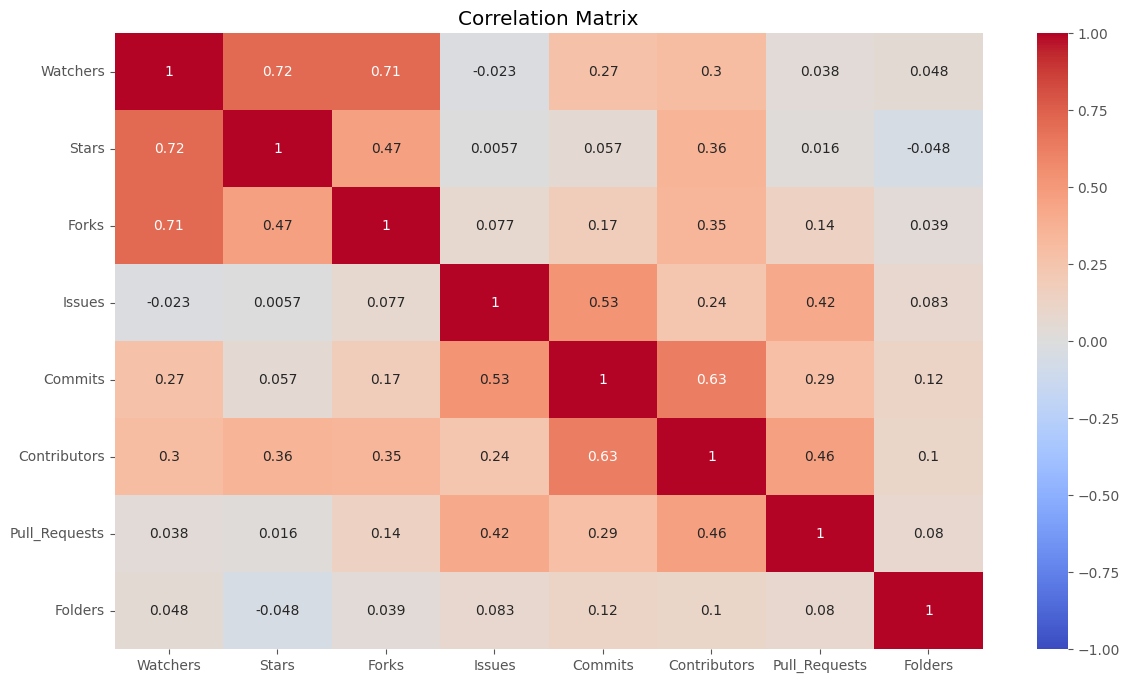

In [181]:
import seaborn as sns

# Remove non-numeric columns and compute correlation matrix
project_info_cleaned = project_info_cleaned.drop(columns=['Name', 'Language'])
correlation_matrix = project_info_cleaned.corr()

# Plot correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Your Interpretation:** Watchers is strongly correlated to stars and forks. In addition to this, commits and contributors are correlated.

### 2.2. Linear regression

1. Use linear regression to try to predict the number of Stars based on Forks, Pull Requests, and Number of Folders. Explain why this is not a very good model by discussing the R-squared , F-statistic p-value, and coefficient  p-values. 
+ Develop another model which is better. Explain why it is better and interpret your results. Hint: try using other variables such as Watches and/or Contributors. 

In [182]:
# First regression model
model_ols = sm.ols(formula= "Stars ~ Forks + Pull_Requests + Folders", data=project_info_cleaned).fit()
model_ols.summary()
                   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     8.356
Date:                Mon, 11 Mar 2024   Prob (F-statistic):           6.15e-05
Time:                        17:07:20   Log-Likelihood:                -1071.8
No. Observations:                  90   AIC:                             2152.
Df Residuals:                      86   BIC:                             2162.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.913e+04   6917.005      7.102      0.000    3.54e+04    6.29e+04
Forks             1.5579      0.313      4.976      0.000       0.936       2.180
Pull_Requests   -12.8475     26.268     -0.489      0.626     -65.066      39.371
Folders        -181.0699    272.374     -0.665      0.508    -722.532     360.392
==============================================================================
Omnibus:                      108.618   Durbin-Watson:                   0.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1759.406
Skew:                           3.991   Prob(JB):                         0.00
Kurtosis:                      23.136   Cond. No.                     3.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [183]:
# Second regression model
regession_cleaned = project_info_cleaned.dropna().astype(int)
model_ols = sm.ols(formula= "Stars ~ Watchers + Forks + Issues + Commits + Contributors + Pull_Requests + Folders", data=regession_cleaned).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     23.75
Date:                Mon, 11 Mar 2024   Prob (F-statistic):           4.32e-16
Time:                        17:07:21   Log-Likelihood:                -871.48
No. Observations:                  77   AIC:                             1759.
Df Residuals:                      69   BIC:                             1778.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.194e+04   5057.705      4.337      0.000    1.18e+04     3.2e+04
Watchers         15.9914      2.106      7.593      0.000      11.790      20.193
Forks            -0.4085      0.305     -1.341      0.184      -1.016       0.199
Issues            3.3839      2.280      1.484      0.142      -1.165       7.933
Commits          -0.6476      0.234     -2.768      0.007      -1.114      -0.181
Contributors     20.0876      4.505      4.459      0.000      11.101      29.074
Pull_Requests    -1.6238     20.612     -0.079      0.937     -42.744      39.496
Folders        -219.2830    158.382     -1.385      0.171    -535.246      96.680
==============================================================================
Omnibus:                       34.415   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.320
Skew:                           1.167   Prob(JB):                     1.54e-35
Kurtosis:                       9.673   Cond. No.                     5.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Your interpretation:** TODO